In [19]:
# libraries for dataframe and visualization
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt

# libraries for clustering 
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.metrics import silhouette_score
from scipy.cluster.hierarchy import linkage
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import cut_tree

In [20]:
df = pd.read_excel('sales_original_no_tabs.xlsx')

In [21]:
df = df.replace({'Null': None})
df.head()

,title,InvoiceNo,StockCode,Quantity,CustomerID,Country,rating,review_count,price,product_type,total_sale,ASIN,invoice_date,invoice_time
0,Nikon D3500 W/ AF-P DX NIKKOR 18-55mm f/3.5-5....,78536597,21703,4,18011.0,Germany,4.6,1399,496.95,dslr camera,1987.80,B07GWKDLGT,2018-12-01,17
1,"Manfrotto Element Aluminum 5-Section Monopod, ...",78536597,40001,4,18011.0,Germany,4.6,289,39.99,dslr camera,159.96,B01MTLH408,2018-12-01,17
2,"STK LP-E8 Battery for Canon Rebel T5i, T3i, T2...",78536597,85034A,1,18011.0,Germany,4.4,333,12.99,dslr camera,12.99,B0064FS7HI,2018-12-01,17
3,Lowepro Whistler BP 350 AW (Grey) . Profession...,78536597,72798C,1,18011.0,Germany,4.3,86,199.99,dslr camera,199.99,B013JHU5YG,2018-12-01,17
4,Samsung (MB-ME32GA/AM) 32GB 95MB/s (U1) microS...,78536597,20726,1,18011.0,Germany,4.7,15717,7.49,dslr camera,7.49,B06XWN9Q99,2018-12-01,17


In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 554417 entries, 0 to 554416
Data columns (total 14 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   title         554417 non-null  object        
 1   InvoiceNo     554417 non-null  object        
 2   StockCode     554417 non-null  object        
 3   Quantity      554417 non-null  int64         
 4   CustomerID    415102 non-null  float64       
 5   Country       554417 non-null  object        
 6   rating        554417 non-null  float64       
 7   review_count  554417 non-null  int64         
 8   price         554417 non-null  float64       
 9   product_type  554417 non-null  object        
 10  total_sale    554417 non-null  float64       
 11  ASIN          546019 non-null  object        
 12  invoice_date  554417 non-null  datetime64[ns]
 13  invoice_time  554417 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(3), object(6)
memory usage: 

In [23]:
df.isnull().sum()

title                0
InvoiceNo            0
StockCode            0
Quantity             0
CustomerID      139315
Country              0
rating               0
review_count         0
price                0
product_type         0
total_sale           0
ASIN              8398
invoice_date         0
invoice_time         0
dtype: int64

In [24]:
df.shape

(554417, 14)

In [25]:
df = df.dropna()
df.shape

(409035, 14)

In [26]:
df.loc['CustomerID'] = df['CustomerID'].astype(str)

### Buying Pattern Analysis

##### Analysis based on 3 factors:
##### 1. Recency: number of days since last purchase
##### 2. Frequency: number of transactions
##### 3. Monetary: total amount of transactions (revenue contributed)

In [27]:
# New Attribute: Monetary
x = df['Quantity']*df['price']
df['Amount']  = x
df_m = df.groupby('CustomerID')['total_sale'].sum()
df_m = df_m.reset_index()
df_m.head()

,CustomerID,total_sale
0,12346.0,4433604.10
1,12347.0,210263.69
2,12348.0,174939.60
3,12349.0,42183.30
4,12350.0,17937.80


In [28]:
# New Attribute: Frequency
df_f = df.groupby('CustomerID')['InvoiceNo'].count()
df_f = df_f.reset_index()
df_f.columns = ['CustomerID', 'Freuency']
df_f.head()

,CustomerID,Freuency
0,12346.0,1
1,12347.0,186
2,12348.0,28
3,12349.0,72
4,12350.0,16


In [29]:
# Merging the two dfs
df_merged = pd.merge(df_m, df_f, on = 'CustomerID', how='inner')
df_merged.head()

,CustomerID,total_sale,Freuency
0,12346.0,4433604.10,1
1,12347.0,210263.69,186
2,12348.0,174939.60,28
3,12349.0,42183.30,72
4,12350.0,17937.80,16


In [30]:
# Compute the maximum date to know the last trasaction date
max_date = max(df['invoice_date'])
max_date

Timestamp('2019-12-09 00:00:00')

In [31]:
# Compute last trasaction date to get the recency of customers
df_p = df.groupby('CustomerID')['invoice_date'].max()
df_p = df_p.reset_index()
df_p.head()

,CustomerID,invoice_date
0,12346.0,2019-01-18
1,12347.0,2019-12-07
2,12348.0,2019-09-25
3,12349.0,2019-11-21
4,12350.0,2019-02-02


In [32]:
today_date = pd.to_datetime('today').normalize()
df_p['Diff'] = (today_date - df_p['invoice_date']).dt.days
df_p.head()

,CustomerID,invoice_date,Diff
0,12346.0,2019-01-18,1231
1,12347.0,2019-12-07,908
2,12348.0,2019-09-25,981
3,12349.0,2019-11-21,924
4,12350.0,2019-02-02,1216


In [33]:
df_p = df_p.drop(['invoice_date'], axis=1)

In [34]:
df_merged = pd.merge(df_merged, df_p, on='CustomerID', how='inner')
df_merged.columns = ['CustomerID', 'Amount', 'Frequency', 'Recency']
df_merged.head()

,CustomerID,Amount,Frequency,Recency
0,12346.0,4433604.10,1,1231
1,12347.0,210263.69,186,908
2,12348.0,174939.60,28,981
3,12349.0,42183.30,72,924
4,12350.0,17937.80,16,1216


Text(0.5, 0, 'Features')

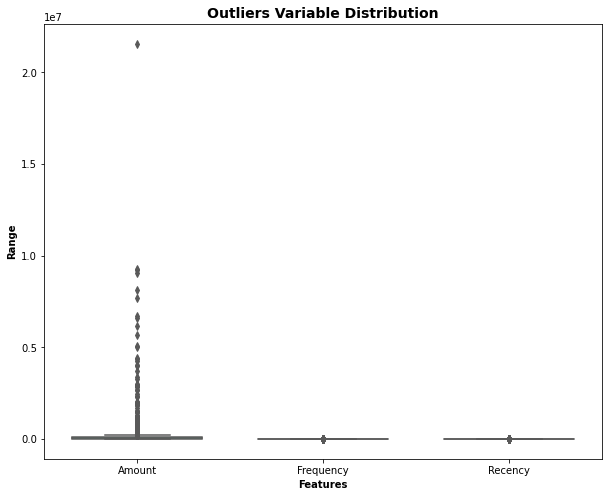

In [35]:
# Outlier Analysis

features = ['Amount', 'Frequency', 'Recency']
plt.rcParams['figure.figsize'] = [10,8]
sns.boxplot(data = df_merged[features], orient='v', palette='Set2', whis=1.5, saturation=1, width=0.7)
plt.title('Outliers Variable Distribution', fontsize= 14, fontweight='bold')
plt.ylabel('Range', fontweight= 'bold')
plt.xlabel('Features', fontweight= 'bold')


In [36]:
# Removing outliers for Amount 
Q1 = df_merged.Amount.quantile(0.05)
Q3 = df_merged.Amount.quantile(0.95)
IQR = Q3 - Q1
df_merged = df_merged[(df_merged.Amount >= Q1 - 1.5*IQR)  & (df_merged.Amount <= Q3 + 1.5*IQR)]


In [37]:
# Removing outliers for Recency 
Q1 = df_merged.Recency.quantile(0.05)
Q3  = df_merged.Recency.quantile(0.95)
IQR  = Q3 - Q1
df_merged = df_merged[(df_merged.Recency >= Q1 - 1.5*IQR) & (df_merged.Recency <= Q3 + 1.5*IQR)]


In [38]:
# Removing outliers for Frequency
Q1 = df_merged.Frequency.quantile(0.05)
Q3 = df_merged.Frequency.quantile(0.95)
IQR = Q3 - Q1
df_merged = df_merged[(df_merged.Frequency >= Q1 - 1.5*IQR) & (df_merged.Frequency <= Q3 + 1.5*IQR)]

In [39]:
df_merged.shape

(4259, 4)

In [40]:
df_merged.head()

,CustomerID,Amount,Frequency,Recency
1,12347.0,210263.69,186,908
2,12348.0,174939.60,28,981
3,12349.0,42183.30,72,924
4,12350.0,17937.80,16,1216
5,12352.0,70157.81,82,942


In [41]:
# Rescaling the attributes
df_newfeatures = df_merged[['Amount', 'Frequency', 'Recency']]
df_newfeatures.head()

,Amount,Frequency,Recency
1,210263.69,186,908
2,174939.60,28,981
3,42183.30,72,924
4,17937.80,16,1216
5,70157.81,82,942


In [43]:
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_newfeatures)

In [48]:
df_scaled = pd.DataFrame(df_scaled)
df_scaled.columns = ['Amount', 'Frequency', 'Recency']
df_scaled.head()

,Amount,Frequency,Recency
0,1.153632,1.030115,-0.912135
1,0.841366,-0.496830,-0.183865
2,-0.332205,-0.071605,-0.752514
3,-0.546537,-0.612800,2.160568
4,-0.084910,0.025038,-0.572941


In [81]:
# Step 4: Building the model 

# instantiate KMeans model with some arbitrary 'k'
model_kmeans = KMeans(n_clusters=3, max_iter=50)
model_kmeans.fit(df_scaled)

KMeans(max_iter=50, n_clusters=3)

In [56]:
# Assign the labels to each data point 
label_list = model_kmeans.labels_

array([0, 1, 1, ..., 2, 1, 1], dtype=int32)

In [61]:
model_kmeans.inertia_

3452.329536283157

In [54]:
sorted(Counter(label_list).items())

[(0, 804), (1, 2210), (2, 1010), (3, 235)]

Text(0, 0.5, 'Inertia')

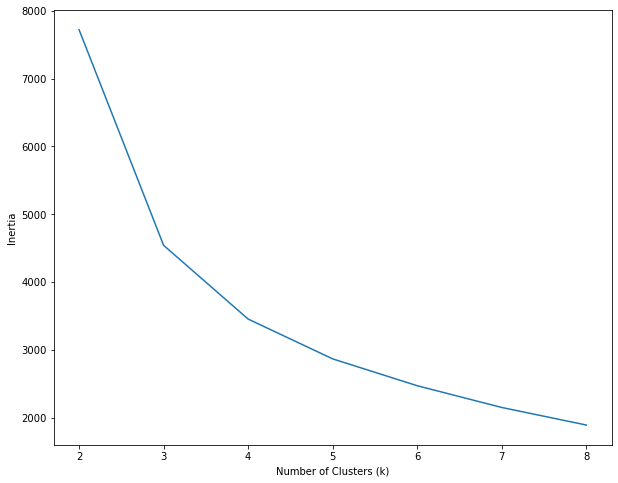

In [87]:
# Selecting optimal 'k'

inertia = []
silhouette = []
range_n_clusters = [2, 3, 4, 5, 6, 7, 8]

for num_clusters in range_n_clusters:
    model_kmeans = KMeans(n_clusters=num_clusters, max_iter=50)
    model_kmeans.fit(df_scaled)

    inertia.append(model_kmeans.inertia_) 
    score = silhouette_score(df_scaled, model_kmeans.labels_, metric='euclidean')
    silhouette.append(score)

# elbow plot 
sns.lineplot(x=range_n_clusters, y=inertia)
plt.show
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')


Text(0, 0.5, 'Silhouette')

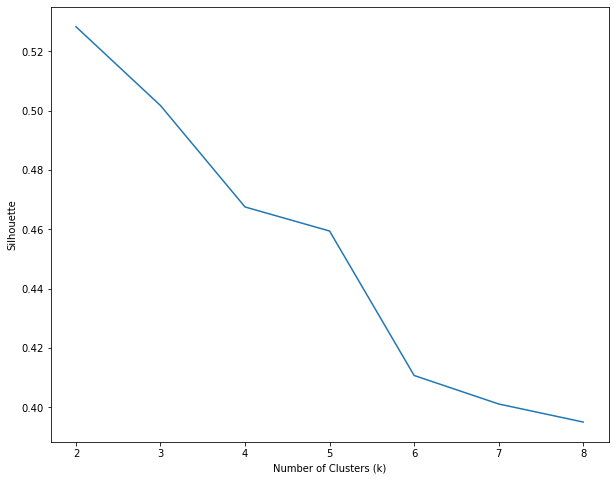

In [90]:
sns.lineplot(x=range_n_clusters, y=silhouette)
plt.show
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Silhouette')

In [91]:
# Final prediction on test with k=3
# test set from df_scaled